In [118]:
import pandas as pd
from typing import List, Union, Iterable
from tqdm.notebook import tqdm
import string
import pymorphy2
import sys
import nltk
import numpy as np
from math import log2, floor
from pympler.asizeof import asizeof


from typing import List, Iterable, Any
from math import log2, floor


def _unary(x: int) -> str:
    return "1" * x + "0"


# ---- GAMMA ENCODING/DECODING ----
# https://en.wikipedia.org/wiki/Elias_gamma_coding
def _gamma_encode(x: int) -> int:
    N = floor(log2(x))
    unary_N = _unary(N)
    # hack to handle removing leading zeroes when converted to int
    # during decoding all 9's are replaced with 0
    if unary_N == "0":
        unary_N = "9"
    bin_x_without_MSB = bin(x)[
        3:
    ]  # for int(20): bin(20) = '10100', without Most significant bit -- '0100'
    return int(unary_N + bin_x_without_MSB)


def gamma_encode_seq(seq: Iterable[int]) -> int:
    encoded_seq = 0
    for s in seq:
        encoded_s = _gamma_encode(s)
        num_of_digits = len(str(encoded_s))
        encoded_seq = encoded_seq * (10**num_of_digits) + encoded_s
    return encoded_seq


def gamma_decode(encoded_seq: int) -> List[int]:  # x = 1110
    encoded_seq = str(encoded_seq).replace("9", "0")
    decoded_seq = []
    while len(encoded_seq) > 0:
        N = encoded_seq.find("0")  # for '11110' it is 4
        bin_decoded = "1" + encoded_seq[N + 1 : 2 * N + 1]  # add most significant bit
        encoded_seq = encoded_seq[2 * N + 1 :]
        # x = '1' + x[num_of_leading_ones + 1:]
        decoded_seq.append(int(bin_decoded, base=2))
    return decoded_seq


# ---- GAMMA ENCODING/DECODING ----


# ---- DELTA ENCODING/DECODING ----
# return zero if string is empty
def handle_empty_binary_string(x: str) -> str:
    return x if len(x) else "0"


def _delta_encode(x) -> int:
    gamma_encoded = str(_gamma_encode(1 + floor(log2(x))))
    binary_without_MSB = bin(x)[
        3:
    ]  # for int(20): bin(20) = '10100', without Most significant bit -- '0100'
    return int(gamma_encoded + binary_without_MSB)


def delta_encode_seq(seq: Iterable[int]) -> int:
    encoded_seq = 0
    for s in seq:
        encoded_s = _delta_encode(s)
        num_of_digits = len(str(encoded_s))
        encoded_seq = encoded_seq * (10**num_of_digits) + encoded_s
    return encoded_seq


# https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D0%BB%D1%8C%D1%82%D0%B0-%D0%BA%D0%BE%D0%B4_%D0%AD%D0%BB%D0%B8%D0%B0%D1%81%D0%B0
def delta_decode(encoded_seq: int) -> List:
    encoded_seq = str(encoded_seq).replace("9", "0")
    decoded_seq = []
    while len(encoded_seq) > 0:
        M = encoded_seq.find("0")  # for '00001' it is 4
        first_part = encoded_seq[M + 1 : M + 1 + M]
        L = 2**M + int(handle_empty_binary_string(first_part), base=2)
        encoded_seq = encoded_seq[M + 1 + M :]
        second_part = encoded_seq[: L - 1]
        N = 2 ** (L - 1) + int(handle_empty_binary_string(second_part), base=2)
        encoded_seq = encoded_seq[L - 1 :]
        decoded_seq.append(N)
    return decoded_seq


# ---- DELTA ENCODING/DECODING ----


def identity(x: Any) -> Any:
    return x



MORPH = pymorphy2.MorphAnalyzer()
nltk.download('stopwords')
STOP_WORDS = nltk.corpus.stopwords.words('russian') 
STOP_WORDS.extend(nltk.corpus.stopwords.words('english') )
STOP_WORDS.extend(['«', '»', '.)', '?.."', '..?', # добавим некоторые пунктуационные знаки из текстов
                '--', '…', '...', '—', '–', '>.',
                ').', '&#', '])', '».', '".',
                '?..', '»,', '",', ',[', "['", "']"])
WORD_TOKENIZER = nltk.WordPunctTokenizer()

def _tokenize_text(text: str):
    # text = text[2:-2]  # delete [''] symbols
    text_tokens = WORD_TOKENIZER.tokenize(text)
    text_tokens = [word for word in text_tokens if (word not in string.punctuation \
                    and word not in STOP_WORDS and not word.isnumeric())]
    text_tokens = [MORPH.parse(x)[0].normal_form for x in text_tokens]
    return text_tokens


class InvertedIndex:
    def __init__(self, csv_paths: Union[List, str], encoding: Union[None, str] = None, encode_differences: bool = True) -> None:
        if isinstance(csv_paths, str):
            self._csv_paths = [csv_paths]
        elif isinstance(csv_paths, list):
            self._csv_paths = csv_paths
        else:
            raise TypeError("csv_paths must be either list or str")
        
        self.index = dict()

        assert encoding in ["gamma", "delta", None], "Only Gamma, Delta encoding is supported. Or none of this."
        self._encoding = encoding
        _encoding_funcs = {
            "gamma": gamma_encode_seq,
            "delta": delta_encode_seq,
            None: identity,
        }
        self._encode = _encoding_funcs[encoding]
        _decoding_funcs = {
            "gamma": gamma_decode,
            "delta": delta_decode,
            None: identity,
        }
        self._decode = _decoding_funcs[encoding]

        self._encode_differences = encode_differences

        print("Processing passed csv_paths")
        self._data_frames = None
        for csv_path in self._csv_paths:
            if self._data_frames is None:
                self._data_frames = pd.read_csv(csv_path, index_col="Unnamed: 0")
                if "Unnamed: 0" in self._data_frames:
                    self._data_frames = self._data_frames.set_index("Unnamed: 0").reset_index(drop=True)
            else:
                df = pd.read_csv(csv_path, index_col="Unnamed: 0")
                if "Unnamed: 0" in df:
                    df = self._data_frames.set_index("Unnamed: 0").reset_index(drop=True)
                self._data_frames = pd.concat([self._data_frames, df])
        self._data_frames['post_id'] = range(1, len(self._data_frames) + 1)

        # no limit for str <-> int conversion (default limit is 4200)
        sys.set_int_max_str_digits(0) 

    def create_inverted_index(self):
        doc_ids = self._data_frames.post_id
        texts = self._data_frames.text
        for doc_id, text in tqdm(zip(doc_ids, texts), total=len(self._data_frames)):
            if doc_id == 50:
                break
            doc_tokens = _tokenize_text(text)
            last = 0
            for token in set(doc_tokens):
                if token not in self.index:
                    self.index[token] = []
                # if self._encode_differences:
                #     delta_diff = doc_id - last
                #     self.index[token].append(delta_diff)
                #     last = doc_id
                # else:
                self.index[token].append(doc_id)

        if self._encode_differences:
            for token in self.index:
                last = 0
                for i, doc_id in enumerate(self.index[token]):
                    current = doc_id
                    self.index[token][i] = current - last
                    last = current

        for token in self.index:
            doc_ids_for_token = self.index[token]
            encoded_doc_ids = self._encode(doc_ids_for_token)
            self.index[token] = encoded_doc_ids

    def search(self, query: str, output_docs: bool = False):
        query_tokens = _tokenize_text(query)
        relevant_doc_ids_for_query = None
        for query_token in query_tokens:
            if query_token not in self.index:
                continue
            encoded_post_lists = self.index[query_token]  # posting_lists
            decoded_post_lists = self._decode(encoded_post_lists)
            relevant_doc_ids_for_token = [decoded_post_lists[0]]
            for doc_id in decoded_post_lists[1:]:
                if self._encode_differences:
                    relevant_doc_ids_for_token.append(relevant_doc_ids_for_token[-1] + doc_id)
                else:
                    relevant_doc_ids_for_token.append(doc_id)

            if relevant_doc_ids_for_query is None:
                relevant_doc_ids_for_query = set(relevant_doc_ids_for_token)
            else:
                relevant_doc_ids_for_query &= set(relevant_doc_ids_for_token)
        relevant_doc_ids_for_query = relevant_doc_ids_for_query if relevant_doc_ids_for_query is not None else set()
        if output_docs:
            docs = self._data_frames[self._data_frames.post_id.isin(relevant_doc_ids_for_query)].text.values
            return relevant_doc_ids_for_query, docs
        return relevant_doc_ids_for_query

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dmsy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [129]:
bitstring = '11111111111111111111111111111111111111111111111111111111111111'

print(f"Size of string: {asizeof(bitstring)} {bitstring.__sizeof__()}")
print(f"Size of int: {asizeof(int(bitstring))} {int(bitstring).__sizeof__()}")
print(f"Size of BitVector: {asizeof(bv)} {bv.__sizeof__()}")
print(f"Size of bytes: {asizeof(bytes([int(b) for b in bitstring]))} {bytes([int(b) for b in bitstring]).__sizeof__()}")
print(f"Size of bytearray: {asizeof(bytearray([int(b) for b in bitstring]))} {bytearray([int(b) for b in bitstring]).__sizeof__()}")

Size of string: 112 111
Size of int: 56 52
Size of BitVector: 576 32
Size of bytes: 96 95
Size of bytearray: 128 126


In [11]:
from __future__ import print_function
from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)

def convert_size(size_bytes):
    import math
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

In [124]:
inverted_index_delta = InvertedIndex(["../data/msu.csv", "../data/spbu.csv",
                                "../data/postupashki.csv", "../vseros.csv"], encoding=None, encode_differences=False)
inverted_index_delta.create_inverted_index()

Processing passed csv_paths


  0%|          | 0/40000 [00:00<?, ?it/s]

In [125]:
inverted_index_delta.index

{'мочь': [1, 16, 25, 26, 46],
 'специалист': [1, 8, 25, 26, 40],
 'четыре': [1, 5, 40],
 'участие': [1, 3, 26, 29, 35, 39, 44, 47, 48],
 'птица': [1],
 'жить': [1, 39],
 'изз': [1],
 'виктор': [1, 3, 8],
 'гнездовый': [1],
 'благодаря': [1, 3],
 'видеокамера': [1],
 'самка': [1],
 'минприрода': [1],
 'ниша': [1],
 'отложить': [1],
 'главный': [1, 25],
 'желать': [1, 3, 17],
 'откладывать': [1],
 'появиться': [1, 8],
 'новостимга': [1, 3, 8, 9, 22, 43],
 'соколысапсать': [1],
 'экоцентр': [1],
 'страна': [1, 5, 29, 43, 44],
 'принимать': [1, 3, 26, 29, 44],
 'ожидать': [1],
 'садовничий': [1, 3, 5, 8],
 'красный': [1, 9],
 'мгу': [1,
  3,
  4,
  5,
  7,
  8,
  9,
  10,
  11,
  12,
  14,
  15,
  16,
  17,
  18,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  32,
  33,
  34,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  44,
  45,
  46,
  47,
  48,
  49],
 'программа': [1, 15, 16, 21, 26, 30, 32, 35, 47],
 'соколасапсан': [1],
 'на': [1, 16, 22, 25, 26, 29, 37, 42, 47, 49

In [85]:
inverted_index_delta = InvertedIndex(["./data/msu.csv", "./data/spbu.csv",
                                "./data/postupashki.csv", "./data/vseros.csv"], encoding="delta", encode_differences=True)
inverted_index_delta.create_inverted_index()

Processing passed csv_paths


  0%|          | 0/40000 [00:00<?, ?it/s]

In [86]:
convert_size(asizeof(inverted_index_delta.index)), convert_size(total_size(inverted_index_delta.index)), inverted_index_delta.index.__sizeof__()

('7.93 MB', '7.9 MB', 147536)

In [ ]:
rektor, rektor_docs = inverted_index_delta.search("ректор", True)
spbu, spbu_docs = inverted_index_delta.search("спбгу", True)

rektor & spbu

In [91]:
inverted_index_gamma = InvertedIndex(["./data/msu.csv", "./data/spbu.csv",
                                "./data/postupashki.csv", "./data/vseros.csv"], encoding="gamma")
inverted_index_gamma.create_inverted_index()

Processing passed csv_paths


  0%|          | 0/40000 [00:00<?, ?it/s]

In [92]:
convert_size(asizeof(inverted_index_gamma.index)), convert_size(total_size(inverted_index_gamma.index)), inverted_index_gamma.index.__sizeof__()

('8.55 MB', '8.53 MB', 147536)

In [96]:
convert_size(asizeof(inverted_index_gamma.index['игра'])), convert_size(total_size(inverted_index_gamma.index['игра']))

('4.39 KB', '4.39 KB')

In [93]:
inverted_index_none = InvertedIndex(["./data/msu.csv", "./data/spbu.csv",
                                "./data/postupashki.csv", "./data/vseros.csv"], encoding=None)
inverted_index_none.create_inverted_index()

Processing passed csv_paths


  0%|          | 0/40000 [00:00<?, ?it/s]

In [94]:
convert_size(asizeof(inverted_index_none.index)), convert_size(total_size(inverted_index_none.index)), inverted_index_none.index.__sizeof__()

('16.83 MB', '16.8 MB', 147536)

In [95]:
convert_size(asizeof(inverted_index_none.index['игра'])), convert_size(total_size(inverted_index_none.index['игра']))

('8.99 KB', '8.95 KB')

In [361]:
def int_to_bytes(x: int) -> bytes:
    return x.to_bytes((x.bit_length() + 7) // 8, 'big')
    
def int_from_bytes(xbytes: bytes) -> int:
    return int.from_bytes(xbytes, 'big')

x = 10 ** 42000
x_s = '1' * 42000
print(asizeof(x), asizeof(int_to_bytes(x)), asizeof(x_s))

18632 17480 42056


In [42]:
from inverted_index import InvertedIndex
from pympler.asizeof import asizeof

def convert_size(size_bytes):
    import math
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

# Gamma encoding

## Without differences encoding

In [39]:
from inverted_index import InvertedIndex



inverted_index_gamma_no_diff = InvertedIndex([
    "../data/msu.csv", "../data/spbu.csv",
    "../data/postupashki.csv", "../data/vseros.csv"],
    encoding="gamma",
    encode_differences=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dmsy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Processing passed csv_paths


In [40]:
inverted_index_gamma_no_diff.create_inverted_index()

  0%|          | 0/40000 [00:00<?, ?it/s]

In [43]:
convert_size(asizeof(inverted_index_gamma_no_diff.index)) 

'31.31 MB'

In [44]:
len(inverted_index_gamma_no_diff.search("Ректор СПбГУ"))  # n of docs with "Ректор" & "СПбГУ" in it

155

In [45]:
len(inverted_index_gamma_no_diff.search("Ректор МГУ"))  # n of docs with "Ректор" & "МГУ" in it

1076

In [46]:
len(inverted_index_gamma_no_diff.index)

91683

In [7]:
assert inverted_index_gamma_no_diff.search("ректор") == inverted_index_gamma_no_diff.search("Ректор")

In [8]:
%%timeit -r 10 -n 10

inverted_index_gamma_no_diff.search("Ректор СПбГУ") 

726 ms ± 3.96 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [9]:
%%timeit -r 10 -n 10

inverted_index_gamma_no_diff.search("Ректор МГУ")

652 ms ± 2.06 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


## With differences encoding

In [10]:
from inverted_index import InvertedIndex



inverted_index_gamma_with_diff = InvertedIndex(
    ["../data/msu.csv", "../data/spbu.csv",
    "../data/postupashki.csv", "../data/vseros.csv"],
    encoding="gamma",
    encode_differences=True)

Processing passed csv_paths


In [11]:
inverted_index_gamma_with_diff.create_inverted_index()

  0%|          | 0/40000 [00:00<?, ?it/s]

In [12]:
convert_size(asizeof(inverted_index_gamma_with_diff.index)) 

'22.14 MB'

In [13]:
len(inverted_index_gamma_with_diff.search("Ректор СПбГУ"))  # n of docs with "Ректор" & "СПбГУ" in it

155

In [14]:
%%timeit -r 10 -n 10

inverted_index_gamma_with_diff.search("Ректор СПбГУ") 

19.8 ms ± 626 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [15]:
%%timeit -r 10 -n 10

inverted_index_gamma_with_diff.search("Ректор МГУ")

21.1 ms ± 1.35 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


# Delta encoding

## Without differences encoding

In [16]:
from inverted_index import InvertedIndex


inverted_index_delta_no_diff = InvertedIndex(
    ["../data/msu.csv", "../data/spbu.csv",
    "../data/postupashki.csv", "../vseros.csv"],
    encoding="delta",
    encode_differences=False)

Processing passed csv_paths


In [17]:
inverted_index_delta_no_diff.create_inverted_index()

  0%|          | 0/40000 [00:00<?, ?it/s]

In [19]:
convert_size(asizeof(inverted_index_delta_no_diff.index))

'24.2 MB'

In [20]:
len(inverted_index_delta_no_diff.search("Ректор СПбГУ"))  # n of docs with "Ректор" & "СПбГУ" in it

155

In [21]:
rektor = inverted_index_delta_no_diff.search("Ректор")
spbu = inverted_index_delta_no_diff.search("спбгу")
len(rektor & spbu)

155

In [22]:
len(inverted_index_delta_no_diff.search("дом"))  # n of docs with "Ректор" & "СПбГУ" in it

446

In [23]:
%%timeit -r 10 -n 10

inverted_index_delta_no_diff.search("Ректор СПбГУ") 

464 ms ± 1.26 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [24]:
%%timeit -r 10 -n 10

inverted_index_delta_no_diff.search("Ректор МГУ")

417 ms ± 2.87 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


## With differences encoding

In [25]:
from inverted_index import InvertedIndex


inverted_index_delta_with_diff = InvertedIndex(
    ["../data/msu.csv", "../data/spbu.csv",
    "../data/postupashki.csv", "../data/vseros.csv"],
    encoding="delta",
    encode_differences=True)

Processing passed csv_paths


In [26]:
inverted_index_delta_with_diff.create_inverted_index()

  0%|          | 0/40000 [00:00<?, ?it/s]

In [27]:
convert_size(asizeof(inverted_index_delta_with_diff.index)) 

'21.5 MB'

In [28]:
len(inverted_index_delta_with_diff.search("Ректор СПбГУ"))  # n of docs with "Ректор" & "СПбГУ" in it

155

In [29]:
%%timeit -r 10 -n 10

inverted_index_delta_with_diff.search("Ректор СПбГУ") 

26.4 ms ± 695 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [30]:
%%timeit -r 10 -n 10

inverted_index_delta_with_diff.search("Ректор МГУ")

29.4 ms ± 924 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


# No encoding

## Without differences encoding

In [31]:
from inverted_index import InvertedIndex


inverted_index_none_no_diff = InvertedIndex(
    ["../data/msu.csv", "../data/spbu.csv",
    "../data/postupashki.csv", "../data/vseros.csv"],
    encoding=None,
    encode_differences=False)

Processing passed csv_paths


In [32]:
inverted_index_none_no_diff.create_inverted_index()

  0%|          | 0/40000 [00:00<?, ?it/s]

In [33]:
convert_size(asizeof(inverted_index_none_no_diff.index)) 

'32.14 MB'

In [34]:
len(inverted_index_none_no_diff.search("Ректор СПбГУ"))  # n of docs with "Ректор" & "СПбГУ" in it

155

In [35]:
%%timeit -r 10 -n 10

inverted_index_none_no_diff.search("Ректор СПбГУ") 

1.36 ms ± 63.3 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [36]:
%%timeit -r 10 -n 10

inverted_index_none_no_diff.search("Ректор МГУ")

1.5 ms ± 51.6 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


## With differences encoding

In [37]:
from inverted_index import InvertedIndex


inverted_index_none_with_diff = InvertedIndex(
    ["../data/msu.csv", "../data/spbu.csv",
    "../data/postupashki.csv", "../data/vseros.csv"],
    encoding=None,
    encode_differences=True)

Processing passed csv_paths


In [38]:
inverted_index_none_with_diff.create_inverted_index()

  0%|          | 0/40000 [00:00<?, ?it/s]

In [39]:
convert_size(asizeof(inverted_index_none_with_diff.index)) 

'40.98 MB'

In [40]:
len(inverted_index_none_with_diff.search("Ректор СПбГУ"))  # n of docs with "Ректор" & "СПбГУ" in it

155

In [41]:
len(inverted_index_none_with_diff.index)

91683

In [42]:
%%timeit -r 10 -n 100

inverted_index_none_with_diff.search("Ректор СПбГУ") 

1.55 ms ± 19.5 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [43]:
%%timeit -r 10 -n 100

inverted_index_none_with_diff.search("Ректор МГУ")

1.71 ms ± 20.3 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


# Plots

In [1]:
import matplotlib.pyplot as plt

In [2]:
memory = {
    "gamma_without": 31.31,
    "gamma_with": 22.14,
    "delta_without": 24.2,
    "delta_with": 21.5,
    "none_without": 32.14,
    "none_with": 40.98,
}

spbu_query = {
    "gamma_without": 726,
    "gamma_with": 19.8,
    "delta_without": 464,
    "delta_with": 26.4,
    "none_without": 1.36,
    "none_with": 1.55,
}

msu_query = {
    "gamma_without": 652,
    "gamma_with": 21.1,
    "delta_without": 417,
    "delta_with": 29.4,
    "none_without": 1.5,
    "none_with": 1.71,
}

## Memory plot

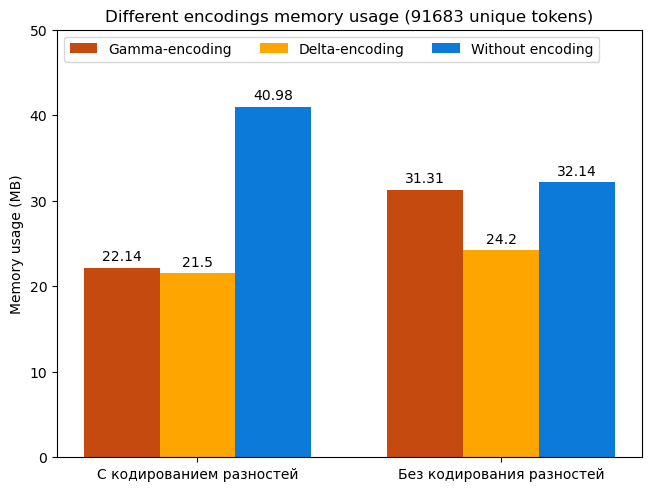

In [53]:
import matplotlib.pyplot as plt
import numpy as np

encoding_type = ("С кодированием разностей", "Без кодирования разностей")
encoding_memory_usage = {
    'Gamma-encoding': (22.14, 31.31),
    'Delta-encoding': (21.5, 24.2),
    'Without encoding': (40.98, 32.14),
}

x = np.arange(len(encoding_type))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

c = ['#c54a10', 'orange', '#0c7ad8']
for i, (attribute, measurement) in enumerate(encoding_memory_usage.items()):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=c[i])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Memory usage (MB)')
ax.set_title('Different encodings memory usage (91683 unique tokens)')
ax.set_xticks(x + width, encoding_type)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 50)

# plt.show()
fig.savefig("../data/memory_usage.png", dpi=300)

## Query plot

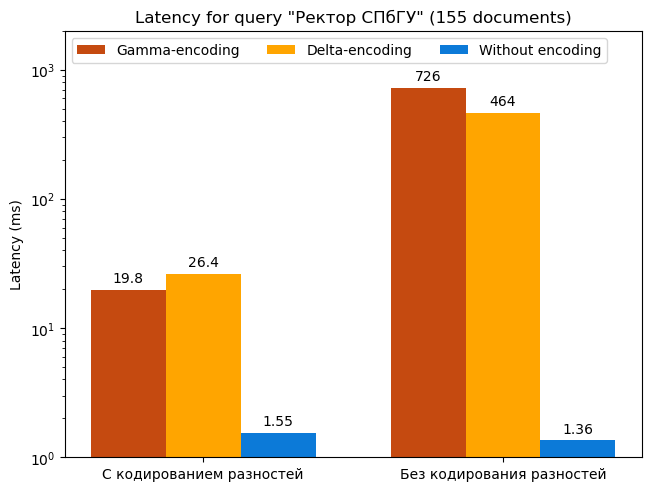

In [54]:
import matplotlib.pyplot as plt
import numpy as np

encoding_type = ("С кодированием разностей", "Без кодирования разностей")
encoding_latency = {
    'Gamma-encoding': (19.8, 726),
    'Delta-encoding': (26.4, 464),
    'Without encoding': (1.55, 1.36),
}


x = np.arange(len(encoding_type))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

c = ['#c54a10', 'orange', '#0c7ad8']
for i, (attribute, measurement) in enumerate(encoding_latency.items()):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=c[i])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Latency (ms)')
ax.set_title('Latency for query "Ректор СПбГУ" (155 documents)')
ax.set_xticks(x + width, encoding_type)
ax.legend(loc='upper left', ncols=3)
ax.set_yscale('log')
ax.set_ylim(1, 2000)

# plt.show()
fig.savefig("../data/latency_spbu.png", dpi=300)

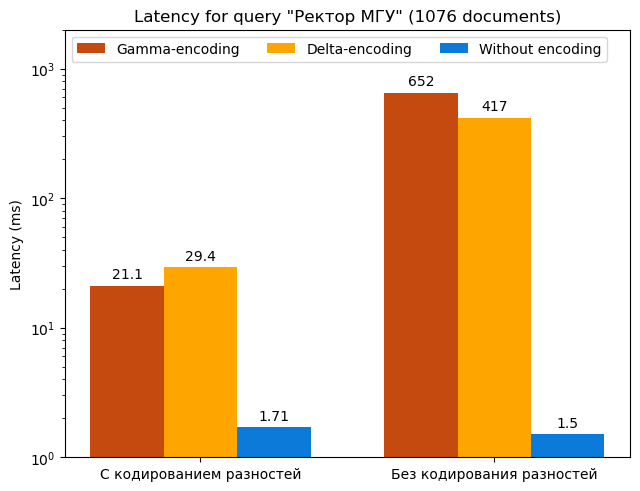

In [55]:
import matplotlib.pyplot as plt
import numpy as np

encoding_type = ("С кодированием разностей", "Без кодирования разностей")
encoding_latency = {
    'Gamma-encoding': (21.1, 652),
    'Delta-encoding': (29.4, 417),
    'Without encoding': (1.71, 1.5),
}


x = np.arange(len(encoding_type))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

c = ['#c54a10', 'orange', '#0c7ad8']
for i, (attribute, measurement) in enumerate(encoding_latency.items()):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=c[i])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Latency (ms)')
ax.set_title('Latency for query "Ректор МГУ" (1076 documents)')
ax.set_xticks(x + width, encoding_type)
ax.legend(loc='upper left', ncols=3)
ax.set_yscale('log')
ax.set_ylim(1, 2000)
# ax.grid()

plt.show()
fig.savefig("../data/latency_msu.png", dpi=300)